Compare to [R solution](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

In [1]:
!pip install /Users/johnmount/Documents/work/pyvtreat/dist/vtreat-0.1.tar.gz
#!pip install https://github.com/WinVector/pyvtreat/raw/master/dist/vtreat-0.1.tar.gz

Processing /Users/johnmount/Documents/work/pyvtreat/dist/vtreat-0.1.tar.gz
  Stored in directory: /Users/johnmount/Library/Caches/pip/wheels/28/d1/8a/f8f4ee7c515a6c18d95d64f4d49327fe498b9e6e23d04c7159
Successfully built vtreat
  Found existing installation: vtreat 0.1
    Uninstalling vtreat-0.1:
      Successfully uninstalled vtreat-0.1


First read in data

In [2]:
import pandas

dir = "../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

In [3]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [4]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

arrange test/train split

In [5]:
import numpy.random

n = d.shape[0]
is_train = numpy.random.uniform(size=n)<=0.9
is_test = numpy.logical_not(is_train)

In [6]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Treat variables

In [7]:
import vtreat

In [8]:
plan = vtreat.binomial_outcome_treatment(outcomename="y", outcometarget=True)

In [9]:
cross_frame = plan.fit_transform(d_train, churn_train)

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [23]:
plan.score_frame_

,variable,PearsonR,significance
0,Var1_is_bad,0.006091,1.959571e-01
1,Var2_is_bad,0.017877,1.471482e-04
2,Var3_is_bad,0.017845,1.512371e-04
3,Var4_is_bad,0.018755,6.825013e-05
4,Var5_is_bad,0.018058,1.259566e-04
5,Var6_is_bad,-0.032394,6.005684e-12
6,Var7_is_bad,-0.029554,3.472688e-10
7,Var9_is_bad,0.006091,1.959571e-01
8,Var10_is_bad,0.018058,1.259566e-04
9,Var11_is_bad,0.017845,1.512371e-04


In [10]:
cross_frame.head()

,Var1_is_bad,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var9_is_bad,Var10_is_bad,Var11_is_bad,...,Var228_impact_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var228_lev_55YFVY9,Var228_lev_ib5G6X1eUxUn6,Var229_impact_code,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.000340,0.655028,1,0,0,0.000731,0.569001,1,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.000313,0.053018,0,0,1,0.000101,0.233923,0,1,0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.001725,0.655028,1,0,0,-0.001637,0.195412,0,0,1
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.000313,0.018789,0,0,0,0.000101,0.233923,0,1,0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.000340,0.087291,0,1,0,-0.000963,0.233923,0,1,0


In [11]:
import xgboost

In [12]:

fd = xgboost.DMatrix(data=cross_frame, label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [13]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.072495,0.001162,0.072783,0.002529
1,0.072528,0.001135,0.072539,0.002267
2,0.072451,0.001237,0.072606,0.002344
3,0.072540,0.001134,0.072539,0.002267
4,0.072540,0.001134,0.072517,0.002242


In [14]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
28,0.071641,0.001005,0.072029,0.00213


In [15]:
ntree = best.index.values[0]
ntree

28

In [16]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=28,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [17]:
model = fitter.fit(cross_frame, churn_train)




In [18]:
test_processed = plan.transform(d_test)

In [19]:

pf = pandas.DataFrame({"churn":churn_test})
preds = model.predict_proba(test_processed)



In [20]:
pf["pred"] = preds[:, 1]

In [21]:
import wvpy.util

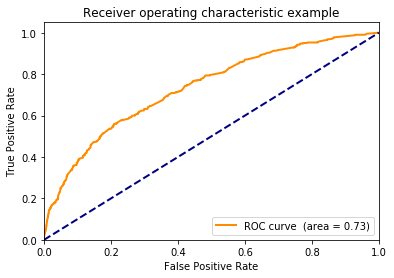

0.734023509361799

In [22]:
wvpy.util.plot_roc(pf["pred"], pf["churn"])